<a href="https://colab.research.google.com/github/makaroniletus1783/mahjong_app/blob/inaba_sub/mahjong_ssd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# PyTorchバージョン変更
! pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 703.8 MB 12 kB/s 
     |████████████████████████████████| 6.6 MB 32.4 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0+cu116
    Uninstalling torch-1.13.0+cu116:
      Successfully uninstalled torch-1.13.0+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0+cu116
    Uninstalling torchvision-0.14.0+cu116:
      Successfully uninstalled torchvision-0.14.0+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.0 requires torch==1.13.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.13.0+cu116 requires torch==1.13.0, but you have torch 1.5.0+cu101 which

In [ ]:
%cd drive/MyDrive/Colab Notebooks/pytorch_ssd

/content/drive/MyDrive/Colab Notebooks/pytorch_ssd


In [ ]:
! wget -P weights https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth

--2022-11-09 03:35:36--  https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.203.176
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.203.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105151288 (100M) [application/x-www-form-urlencoded]
Saving to: ‘weights/ssd300_mAP_77.43_v2.pth’

ssd300_mAP_77.43_v2 100%[===================>] 100.28M  23.9MB/s    in 4.7s    

2022-11-09 03:35:41 (21.2 MB/s) - ‘weights/ssd300_mAP_77.43_v2.pth’ saved [105151288/105151288]



In [ ]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ecdd1ccf-87ed-5c7d-ebfc-8e51c20c6717)


In [ ]:
!wget -P models https://storage.googleapis.com/models-hao/mobilenet-v1-ssd-mp-0_675.pth

--2022-12-09 05:03:31--  https://storage.googleapis.com/models-hao/mobilenet-v1-ssd-mp-0_675.pth
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37995286 (36M) [application/octet-stream]
Saving to: ‘models/mobilenet-v1-ssd-mp-0_675.pth’

mobilenet-v1-ssd-mp 100%[===================>]  36.23M  19.5MB/s    in 1.9s    

2022-12-09 05:03:33 (19.5 MB/s) - ‘models/mobilenet-v1-ssd-mp-0_675.pth’ saved [37995286/37995286]



In [ ]:
# BCCDデータの読み込み
from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform
testset = VOCDetection(VOC_ROOT, [('MAHJONG', 'test')], None, VOCAnnotationTransform())

In [ ]:
from data import *
from utils.augmentations import SSDAugmentation
from layers.modules import MultiBoxLoss
from ssd import build_ssd
import os
import sys
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torch.utils.data as data
import numpy as np
import argparse
import warnings  
warnings.filterwarnings('ignore')  

# 初期設定
args = {'dataset':'MAHJONG',   
        'basenet':'vgg16_reducedfc.pth',
        'batch_size':32,
        'resume': 'ssd300_mAP_77.43_v2.pth',
        'max_iter':500,
        'num_workers':4,  
        'cuda':True,
        'lr':0.001,
        'lr_steps':(8000, 10000, 12000),  
        'momentum':0.9,
        'weight_decay':5e-4,
        'gamma':0.1,
        'save_folder':'weights/'
       }



# Tensor作成時のデフォルトにGPU Tensorを設定
if torch.cuda.is_available():
    if args['cuda']:
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
    if not args['cuda']:
        print("WARNING: It looks like you have a CUDA device, but aren't " +
              "using CUDA.\nRun with --cuda for optimal training speed.")
        torch.set_default_tensor_type('torch.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

# 訓練データの設定
cfg = voc
dataset = VOCDetection(root=VOC_ROOT,
                       transform=SSDAugmentation(cfg['min_dim'],
                                                 MEANS))

# ネットワークの定義
ssd_net = build_ssd('train', cfg['min_dim'], cfg['num_classes'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ssd_net.to(device)

# 学習済みパラメータのロード
voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']

mahjong_classes = ['m1', 'm2', 'm3', 'm4', 'm5', 
              'm6', 'm7', 'm8', 'm9', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 
              's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 'ton', 'nan', 'sha', 'pei', 'haku', 
              'hatu', 'tyun', 'pe']
#NUM_CLASSES = len(mahjong_classes) + 1
#input_shape=(300, 300, 3)
#model = build_ssd(input_shape, num_classes=NUM_CLASSES)


if args['resume']:
    print('Resuming training, loading {}...'.format(args['resume']))
    #model.load_weights(args['save_folder'] + args['resume'], by_name=True)
    ssd_net.load_weights(args['save_folder'] + args['resume'])  
else:
    vgg_weights = torch.load(args['save_folder'] + args['basenet'])
    print('Loading base network...')
    ssd_net.vgg.load_state_dict(vgg_weights)

# GPU設定
if args['cuda']:
    net = torch.nn.DataParallel(ssd_net)
    cudnn.benchmark = True

# learning_rate の段階調整関数
def adjust_learning_rate(optimizer, gamma, step):
    lr = args['lr'] * (gamma ** (step))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# xavierの初期化関数
def xavier(param):
    init.xavier_uniform_(param)

# パラメータ初期化関数
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        xavier(m.weight.data)
        m.bias.data.zero_()

# 新規学習時のパラメータ初期化
if not args['resume']:
    print('Initializing weights...')
    ssd_net.extras.apply(weights_init)
    ssd_net.loc.apply(weights_init)
    ssd_net.conf.apply(weights_init)

# 損失関数の設定
criterion = MultiBoxLoss(cfg['num_classes'], 0.5, True, 0, True, 3, 0.5,
                         False, args['cuda'])

# 最適化手法の設定
optimizer = optim.SGD(net.parameters(), lr=args['lr'], momentum=args['momentum'],
                      weight_decay=args['weight_decay'])

# 訓練モード
net.train()

# データローダの設定
data_loader = data.DataLoader(dataset, args['batch_size'],
                              num_workers=args['num_workers'],
                              shuffle=True, collate_fn=detection_collate,
                              pin_memory=True)

# 学習ループ
step_index = 0
batch_iterator = None
#print(len(dataset) // args['batch_size'])
epoch_size = len(dataset) // args['batch_size']

for iteration in range(args['max_iter']):   
    if (not batch_iterator) or (iteration % epoch_size ==0):
        #print(iter(data_loader))
        batch_iterator = iter(data_loader)
        loc_loss = 0
        conf_loss = 0

    # lrの調整
    if iteration in args['lr_steps']:
        step_index += 1
        adjust_learning_rate(optimizer, args['gamma'], step_index)
        
    # バッチサイズ分のデータをGPUへ
    #print(next(batch_iterator))
    images, targets = next(batch_iterator)
    images = images.to(device) 
    targets = [ann.to(device) for ann in targets]

    # 順伝播
    t0 = time.time()
    out = net(images)

    # 逆伝播
    optimizer.zero_grad()
    loss_l, loss_c = criterion(out, targets)
    loss = loss_l + loss_c
    loss.backward()
    optimizer.step()
    t1 = time.time()
    loc_loss += loss_l.item()
    conf_loss += loss_c.item()
    
    #ログの出力
    if iteration % 10 == 0:
        print('timer: %.4f sec.' % (t1 - t0))
        print('iter ' + repr(iteration) + ' || Loss: %.4f ||' % (loss.item()), end=' ')

# 学習済みモデルの保存
torch.save(ssd_net.state_dict(),
           args['save_folder'] + '' + args['dataset'] + '.pth')

Resuming training, loading ssd300_mAP_77.43_v2.pth...
Loading weights into state dict...
Finished!
timer: 8.7223 sec.
iter 0 || Loss: 12.3940 || timer: 0.3976 sec.
iter 10 || Loss: 5.9088 || timer: 0.4603 sec.
iter 20 || Loss: 5.2984 || timer: 0.5546 sec.
iter 30 || Loss: 5.0234 || timer: 0.7308 sec.
iter 40 || Loss: 4.6819 || timer: 0.5642 sec.
iter 50 || Loss: 4.3855 || timer: 0.5999 sec.
iter 60 || Loss: 4.1109 || timer: 0.4094 sec.
iter 70 || Loss: 3.8495 || timer: 0.6179 sec.
iter 80 || Loss: 3.6625 || timer: 0.5659 sec.
iter 90 || Loss: 3.6709 || timer: 0.5802 sec.
iter 100 || Loss: 3.4000 || timer: 0.5492 sec.
iter 110 || Loss: 3.2190 || timer: 0.6339 sec.
iter 120 || Loss: 3.1685 || timer: 0.4211 sec.
iter 130 || Loss: 3.1297 || timer: 0.5069 sec.
iter 140 || Loss: 3.0501 || timer: 0.6011 sec.
iter 150 || Loss: 2.8857 || timer: 0.6023 sec.
iter 160 || Loss: 2.9892 || timer: 0.5677 sec.
iter 170 || Loss: 2.7194 || timer: 0.6452 sec.
iter 180 || Loss: 2.6755 || timer: 0.4352 sec.

In [ ]:
!pip install matplotlib-venn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!apt-get -qq install -y libfluidsynth1

Selecting previously unselected package libfluidsynth1:amd64.
(Reading database ... 123991 files and directories currently installed.)
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.6) ...


In [ ]:
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 123996 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.2.2-3.1ubuntu0.7_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.2.2-3.1ubuntu0.7) ...
Setting up libarchive-dev:amd64 (3.2.2-3.1ubuntu0.7) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 7.3 MB/s 
  Created wheel for libarchive: filename=libarchive-0.4.7-py3-none-any.whl size=31648 sha256=85dd64ae9162c989a702fe6dc27fb9e8bab9e227ddb1c7fa406b17a46ee4c1c1
  Stored in directory: /root/.cache/pip/wheels/63/b1/c6/b3da79bec2012175bd43603eed98ef8548ac1733b77c1d4330
Successfully built libarchive


In [ ]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install cartopy
import cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 4.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 49.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 40.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 38.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 56.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 46 kB 5.4 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m

In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
 
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2
from ssd import build_ssd
from matplotlib import pyplot as plt
from data import VOC_CLASSES as voc_labels
 
# GPUの設定
torch.cuda.is_available() 
torch.set_default_tensor_type('torch.cuda.FloatTensor')  
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
 
# SSDネットワークを定義し、学習済みパラメータを読み込む
net = build_ssd('test', 300, 21)   
net.load_weights('./weights/ssd300_mAP_77.43_v2.pth')
net = net.to(device)
 
# 物体検出関数 
def detect(image, labels):
 
    # 画像を(1,3,300,300)のテンソルに変換
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x = cv2.resize(image, (300, 300)).astype(np.float32)  
    x -= (104.0, 117.0, 123.0)
    x = x.astype(np.float32)
    x = x[:, :, ::-1].copy()
    x = torch.from_numpy(x).permute(2, 0, 1)  
    xx = Variable(x.unsqueeze(0))    
     
    # 順伝播を実行し、推論結果を出力
    if torch.cuda.is_available():
      xx = xx.cuda()
    y = net(xx)
 
    # 表示設定 
    plt.figure(figsize=(8,8))
    colors = plt.cm.hsv(np.linspace(0, 1, 36)).tolist()
    plt.imshow(rgb_image)
    currentAxis = plt.gca()
 
    # 推論結果をdetectionsに格納
    detections = y.data
    # 各検出のスケールのバックアップ
    scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
    labels_result = []

    # バウンディングボックスとクラス名を表示
    for i in range(detections.size(1)):
        j = 0
        # 確信度confが0.6以上のボックスを表示
        # jは確信度上位200件のボックスのインデックス
        # detections[0,i,j]は[conf,xmin,ymin,xmax,ymax]の形状
        while detections[0,i,j,0] >= 0.6:
            score = detections[0,i,j,0]
            label_name = labels[i-1]
            labels_result.append(labels[i-1])
            display_txt = '%s: %.2f'%(label_name, score)
            pt = (detections[0,i,j,1:]*scale).cpu().numpy()
            coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
            color = colors[i]
            currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
            currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
            j+=1
    plt.show()
    plt.close()
    print(labels_result)
    return detections

Loading weights into state dict...
Finished!


Loading weights into state dict...
Finished!


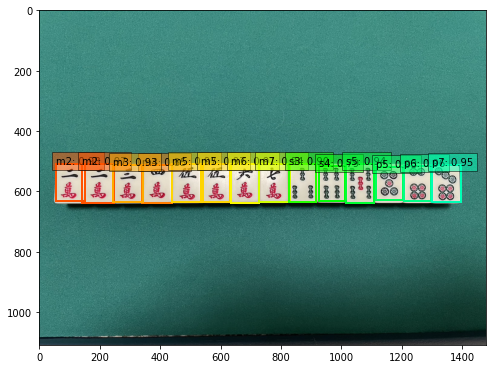

['m2', 'm2', 'm4', 'm3', 'm5', 'm5', 'm6', 'm7', 's3', 's4', 's5', 'p5', 'p6', 'p7']


In [ ]:
import os
import sys
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
 
from ssd import build_ssd
 
# SSDネットワークの定義とパラメータのロード
net = build_ssd('test', 300, 21)    
net.load_weights('./weights/MAHJONG.pth')
 
# BCCD_test 読み込み
from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform
from data import MAHJONG_CLASSES as mahjong_labels
testset = VOCDetection(VOC_ROOT, [('MAHJONG', 'test')], None, VOCAnnotationTransform())
 
# 画像の読み込み
img_id = 0
image = testset.pull_image(img_id)

img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/pytorch_ssd/VOCdevkit/MAHJONG/JPEGImages/Mahjong_0402.jpg")
 
# 物体検出
detections = detect(img, mahjong_labels)